# ANALYZE COMPANY'S SALES

In [1]:
# Load all the needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import scipy.stats as sci
%matplotlib inline
sns.set_style("darkgrid")
sns.set_palette("colorblind")
sns.set_context("talk")
sns.set(rc={'figure.figsize':(11.7,8.27)})

## Reading All Files

In [2]:
transactions = pd.read_csv("datasets/transactions.csv")
customers = pd.read_csv("datasets/customers.csv")
products = pd.read_csv("datasets/products.csv")

In [3]:
transactions.head(2)

,id_prod,date,session_id,client_id
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277


In [4]:
transactions.info(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337016 entries, 0 to 337015
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     337016 non-null  object
 1   date        337016 non-null  object
 2   session_id  337016 non-null  object
 3   client_id   337016 non-null  object
dtypes: object(4)
memory usage: 10.3+ MB


In [5]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8623 non-null   object
 1   sex        8623 non-null   object
 2   birth      8623 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


In [6]:
customers.head(2)

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975


In [7]:
products.head(2)

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0


In [8]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


In [9]:
products.describe()

,price,categ
count,3287.000000,3287.000000
mean,21.856641,0.370246
std,29.847908,0.615387
min,-1.000000,0.000000
25%,6.990000,0.000000
50%,13.060000,0.000000
75%,22.990000,1.000000
max,300.000000,2.000000


## Cleaning All Datasets

### Cleaning transactions dataset  
#### Define

- **Some date starting with test must be split**
- **Date variable must be a *datetime* not a string**  
- **We must split id_prod in category and id_prod**
- **We must split session_id in session id and session_category**
- **We must split client_id in client_id and client_category**
- **Turn all the categories variable into a category data type**

#### Code

In [10]:
# Write  a function to split a column
def split_columns(dataset, col):
    ### This function take a dataset and a column of the dataset split the column and return the 2 new columns
    new_col_1 = dataset[col].apply(lambda x : x.split("_")[1])
    new_col_2 = dataset[col].apply(lambda x : x.split("_")[0].upper())
    return new_col_1, new_col_2

In [11]:
# Create a copy of transactions dataset
transactions_df = transactions.copy()

In [12]:
# Split id_prod in 2 columns,id_prod and category
transactions_df["id_prod"], transactions_df["category"] = split_columns(transactions_df, "id_prod")

In [13]:
# Split client_id columns into 2 columns, client_id and client_category
transactions_df["client_id"], transactions_df["client_category"] = split_columns(transactions_df, "client_id")

In [14]:
# Split session_id in 2 columns, session_id and sesseion_category
transactions_df["session_id"], transactions_df["session_category"] = split_columns(transactions_df, "session_id")

In [15]:
# Check if everything is ok
transactions_df.head(2)

,id_prod,date,session_id,client_id,category,client_category,session_category
0,1483,2021-04-10 18:37:28.723910,18746,4450,0,C,S
1,226,2022-02-03 01:55:53.276402,159142,277,2,C,S


In [16]:
# Check the different categories
transactions_df.query("category == 'T'")

,id_prod,date,session_id,client_id,category,client_category,session_category
1431,0,test_2021-03-01 02:30:02.237420,0,1,T,CT,S
2365,0,test_2021-03-01 02:30:02.237446,0,1,T,CT,S
2895,0,test_2021-03-01 02:30:02.237414,0,1,T,CT,S
5955,0,test_2021-03-01 02:30:02.237441,0,0,T,CT,S
7283,0,test_2021-03-01 02:30:02.237434,0,1,T,CT,S
...,...,...,...,...,...,...,...
332594,0,test_2021-03-01 02:30:02.237445,0,0,T,CT,S
332705,0,test_2021-03-01 02:30:02.237423,0,1,T,CT,S
332730,0,test_2021-03-01 02:30:02.237421,0,1,T,CT,S
333442,0,test_2021-03-01 02:30:02.237431,0,1,T,CT,S


There are 200 rows which date starts with test. We can guess that it was just to *test* if the system is working or not. These rows are not useful for our analysis. We will remove them.
We can therefore notice that the test day was on 2021-03-01 at 02:30:02 am.

In [17]:
# Remove all the test dates
transactions_df = transactions_df.query("category != 'T'") # Select all the rows where the category is not T
transactions_clean = transactions_df.copy() # Create a new dataframe from transactions_df to avoid warnings

In [18]:
# Check if there are still test date, no output means there is no test date anymore
assert transactions_clean.category.all() != "T"

In [19]:
transactions_clean.date = transactions_clean.date.astype("datetime64")

In [20]:
# Assert that the date is in the correct type
transactions_clean.date.head()

0   2021-04-10 18:37:28.723910
1   2022-02-03 01:55:53.276402
2   2021-09-23 15:13:46.938559
3   2021-10-17 03:27:18.783634
4   2021-07-17 20:34:25.800563
Name: date, dtype: datetime64[ns]

In [21]:
# turn all the categories variable into a category data type
transactions_clean.iloc[:, 4:] = transactions_clean.iloc[:, 4:].astype("category")

In [22]:
# Check if the variables are categories
transactions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336816 entries, 0 to 337015
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id_prod           336816 non-null  object        
 1   date              336816 non-null  datetime64[ns]
 2   session_id        336816 non-null  object        
 3   client_id         336816 non-null  object        
 4   category          336816 non-null  category      
 5   client_category   336816 non-null  category      
 6   session_category  336816 non-null  category      
dtypes: category(3), datetime64[ns](1), object(3)
memory usage: 13.8+ MB


### Cleaning customers dataset  
#### Define  
- **Split client_id variable into 2 variables**
- **Turn sex variabble in uppercase**
- **Turn sex variable into category data type**

#### Code

In [23]:
# Make a copy of customers dataset
customers_clean = customers.copy()

In [24]:
# Spllit client_id
customers_clean["client_id"], customers_clean["client_category"] = split_columns(customers_clean, "client_id")

In [25]:
# Turn sex in uppercase
customers_clean.sex = customers_clean.sex.map(lambda x : x.upper())

In [26]:
# Turn sex into category
customers_clean.sex = customers_clean.sex.astype("category")

In [27]:
# Check the final dataset
print(customers_clean.head())
print("=========================================")
customers_clean.info()

  client_id sex  birth client_category
0      4410   F   1967               C
1      7839   F   1975               C
2      1699   F   1984               C
3      5961   F   1962               C
4      5320   M   1943               C
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   client_id        8623 non-null   object  
 1   sex              8623 non-null   category
 2   birth            8623 non-null   int64   
 3   client_category  8623 non-null   object  
dtypes: category(1), int64(1), object(2)
memory usage: 210.7+ KB


### Cleaning products dataset  
#### Define  
- **Categ variable must be category type not an int**
- **Change the categ name to category**  
- **Split the id_prod and keep just the id products**  
- **There is a price of -1, we will remove it**  

#### Code

In [28]:
# Make a copy of the products dataset
products_df = products.copy()

In [29]:
# Change the categ name to category
products_df = products_df.rename(columns={"categ":"category"})

In [30]:
# Split id_prod and keep just the id products using the split_columns function
products_df["id_prod"], products_df["category"] = split_columns(products_df, "id_prod")

In [31]:
# Turn the category into a category type
products_df.category = products_df.category.astype("category")

In [32]:
# Check if everything is correct
products_df.head(2)

,id_prod,price,category
0,1421,19.99,0
1,1368,5.13,0


In [33]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id_prod   3287 non-null   object  
 1   price     3287 non-null   float64 
 2   category  3287 non-null   category
dtypes: category(1), float64(1), object(1)
memory usage: 54.9+ KB


In [34]:
# Check the -1 price row
products_df.query("price == -1")

,id_prod,price,category
731,0,-1.0,T


This is probably another test, we will remove it for a better analysis.

In [35]:
products_clean = products_df.copy()
products_clean = products_clean.query("price != -1")

In [36]:
# Check the description to see if it is ok
products_clean.describe()

,price
count,3286.000000
mean,21.863597
std,29.849786
min,0.620000
25%,6.990000
50%,13.075000
75%,22.990000
max,300.000000


Now that all the datasets are clean we can join them all together in a unique dataset for anaylysis.

In [37]:
# Join all the datasets together
sales_merge = transactions_clean.merge(products_clean, on = ["category", "id_prod"], how = "left")

In [38]:
sales_df = sales_merge.merge(customers_clean, on = ["client_id", "client_category"], how = "left")

In [39]:
# Turn category and client category into categorical variable
sales_df.iloc[:, 4:6] = sales_df.iloc[:, 4:6].astype("category")
# Check if it is ok
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336816 entries, 0 to 336815
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id_prod           336816 non-null  object        
 1   date              336816 non-null  datetime64[ns]
 2   session_id        336816 non-null  object        
 3   client_id         336816 non-null  object        
 4   category          336816 non-null  category      
 5   client_category   336816 non-null  category      
 6   session_category  336816 non-null  category      
 7   price             336713 non-null  float64       
 8   sex               336816 non-null  category      
 9   birth             336816 non-null  int64         
dtypes: category(4), datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 19.3+ MB


We can see that price has less values than the other columns, probably due to missing values. Let us confirm that.

In [40]:
# Check the columns with missing values
sales_df.isna().any()

id_prod             False
date                False
session_id          False
client_id           False
category            False
client_category     False
session_category    False
price                True
sex                 False
birth               False
dtype: bool

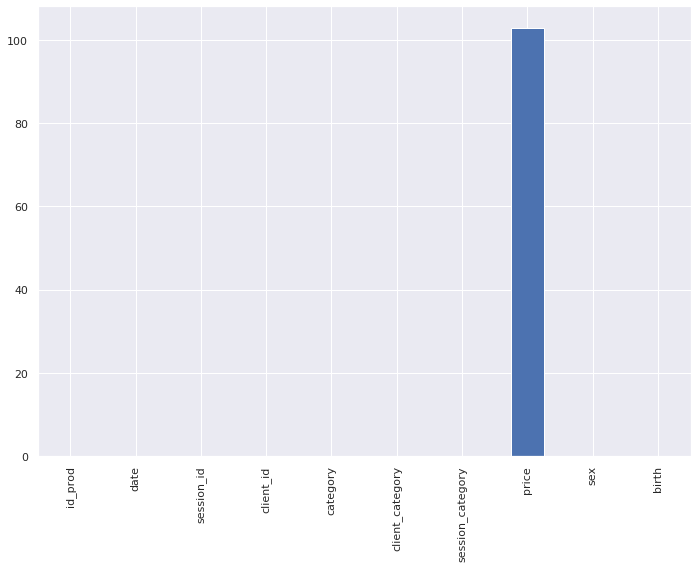

In [41]:
# Plot the missing values
sales_df.isna().sum().plot(kind = "bar");

In [42]:
# Check the id product with missing values
sales_df[sales_df.price.isna()]["id_prod"].unique()

array(['2245'], dtype=object)

There is just one product, It means that the information about this product **(id = 2245)** was not available in the product dataframe.

In [43]:
# Replace the NaN values with the median price
sales_df.price.fillna(sales_df.price.median(), inplace = True)

In [44]:
# Assert that there are no missing values anymore in the dataframe
assert sales_df.isna().all().all() == False

In [45]:
# Create the variable age, max date - birth date
actual_year = sales_df.date.max().year # Find the max year in the dataframe to use as actual year
sales_df["age"] = actual_year - sales_df.birth # Can lead to error if data is not updated over time
sales_df.head(2)

,id_prod,date,session_id,client_id,category,client_category,session_category,price,sex,birth,age
0,1483,2021-04-10 18:37:28.723910,18746,4450,0,C,S,4.99,F,1977,45
1,226,2022-02-03 01:55:53.276402,159142,277,2,C,S,65.75,F,2000,22


In [46]:
# Remove the useless column birth
sales_df = sales_df.drop("birth", axis = 1)
sales_df.head(2)

,id_prod,date,session_id,client_id,category,client_category,session_category,price,sex,age
0,1483,2021-04-10 18:37:28.723910,18746,4450,0,C,S,4.99,F,45
1,226,2022-02-03 01:55:53.276402,159142,277,2,C,S,65.75,F,22


In [47]:
print(sales_df.session_category.unique())
print(sales_df.client_category.unique())

[S]
Categories (1, object): [S]
[C]
Categories (1, object): [C]


client category and session category have just 1 category, those variables are not usefull for the analysis. We will remove them.


In [48]:
sales_clean = sales_df.drop(["client_category", "session_category"], axis = 1)
sales_clean.head(2)

,id_prod,date,session_id,client_id,category,price,sex,age
0,1483,2021-04-10 18:37:28.723910,18746,4450,0,4.99,F,45
1,226,2022-02-03 01:55:53.276402,159142,277,2,65.75,F,22


Let us rename the **sex** variable to **gender**, and **F to female**, **M to male**, for better comprehension.

In [49]:
# Rename sex variable to gender
sales_clean.rename(columns = {"sex":"gender"}, inplace = True)
# Replace F by female and M by male
sales_clean.gender.replace("F", "female", inplace = True)
sales_clean.gender.replace("M", "male", inplace = True)
sales_clean.head()

,id_prod,date,session_id,client_id,category,price,gender,age
0,1483,2021-04-10 18:37:28.723910,18746,4450,0,4.99,female,45
1,226,2022-02-03 01:55:53.276402,159142,277,2,65.75,female,22
2,374,2021-09-23 15:13:46.938559,94290,4270,1,10.71,female,43
3,2186,2021-10-17 03:27:18.783634,105936,4597,0,4.20,male,59
4,1351,2021-07-17 20:34:25.800563,63642,1242,0,8.99,female,42


## ANALYZE THE DATA  

Now that all the datasets are cleaned we can make some analysis. 


**What is the average price of the sales?**

In [50]:
sales_clean.price.describe()

count    336816.000000
mean         17.214175
std          17.852809
min           0.620000
25%           8.610000
50%          13.900000
75%          18.990000
max         300.000000
Name: price, dtype: float64

We have an average price of **17.22** but with a standard deviation of **17.85** which means that there are too much variability between the prices, there are probably outliers. Let's check for the IQR.  

In [51]:
# IQR of the price
def iqr(column) -> float:
    """return the iqr of a given column"""
    return column.quantile(.75) - column.quantile(.25)
# IQR of the price
iqr(sales_clean.price)

10.379999999999999

We have an IQR of around **10**, the variability is high. Let's make a plot.

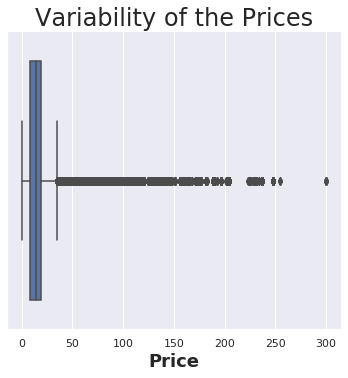

In [52]:
# Boxplot to see the variability
sns.catplot("price", data = sales_clean, kind = "box")
plt.title("Variability of the Prices", fontsize = 24)
plt.xlabel("Price", fontsize = 18, fontweight = "bold");

As we can see there are many outliers. Let's try to find them all. 

In [53]:
# Find all the positive outliers
outliers = sales_clean.price.quantile(0.75)+1.5*iqr(sales_clean.price)
sales_clean.price[sales_clean.price > outliers].sort_values()

34429      34.77
155477     34.77
262595     34.77
162605     34.77
62627      34.77
           ...  
334751    300.00
50216     300.00
115097    300.00
281102    300.00
303214    300.00
Name: price, Length: 20423, dtype: float64

All the price between **34.77** to **300** are outliers. 

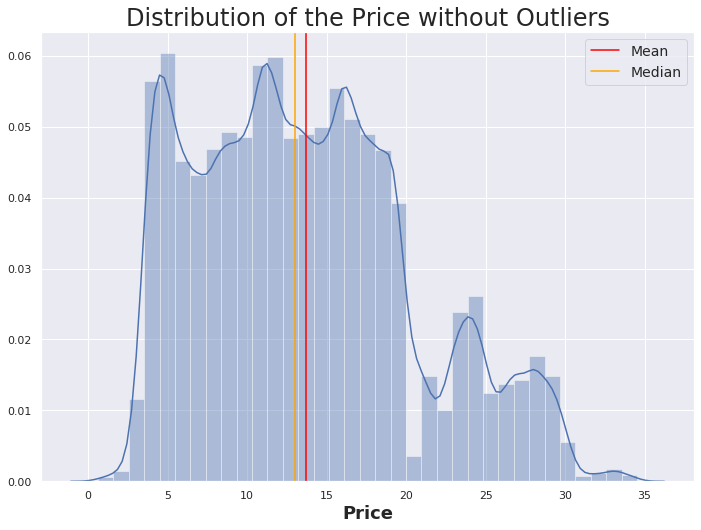

In [54]:
# Boxplot of the outliers values
sales_clean_no_outliers = sales_clean[sales_clean.price < outliers]
sns.distplot(sales_clean_no_outliers.price, bins = 35)
plt.axvline(sales_clean_no_outliers.price.mean(), color = "red")
plt.axvline(sales_clean_no_outliers.price.median(), color = "orange")
plt.legend(["Mean", "Median"], fontsize = 14)
plt.title("Distribution of the Price without Outliers", fontsize = 24)
plt.xlabel("Price", fontsize = 18, fontweight = "bold");

In [55]:
sales_clean_no_outliers.price.agg([np.mean, np.median])

mean      13.721993
median    12.990000
Name: price, dtype: float64

If we remove all the outliers the mean and median are almost the same and are around $13. 

In [56]:
# check the proportion of outliers in the dataframe
sales_clean_outliers = sales_clean.price[sales_clean.price > outliers]
prop_outliers = len(sales_clean_outliers) / len(sales_clean) * 100
prop_outliers

6.063548049973873

The outliers represent about **6%** of the number of sales. Let see what it represent as value

In [57]:
# total sales for the outliers
outliers_total_sales = sales_clean_outliers.sum() / sales_clean.price.sum() * 100
outliers_total_sales

25.120122475412238

Even if the outliers represent just **6%** of the sales, they represent **25%** of the total purchases amount.

In [58]:
# mean, median and mode of the price in the dataframe
print("mean : ",sales_clean.price.mean())
print("median : ",sales_clean.price.median())
print("mode : ",sales_clean.price.mode()[0])

mean :  17.21417471267639
median :  13.9
mode :  15.99


We confirm here that most of the sales are between **0 and 16**, with highest sales at **13.9**

**Which are the categories with more sales?**

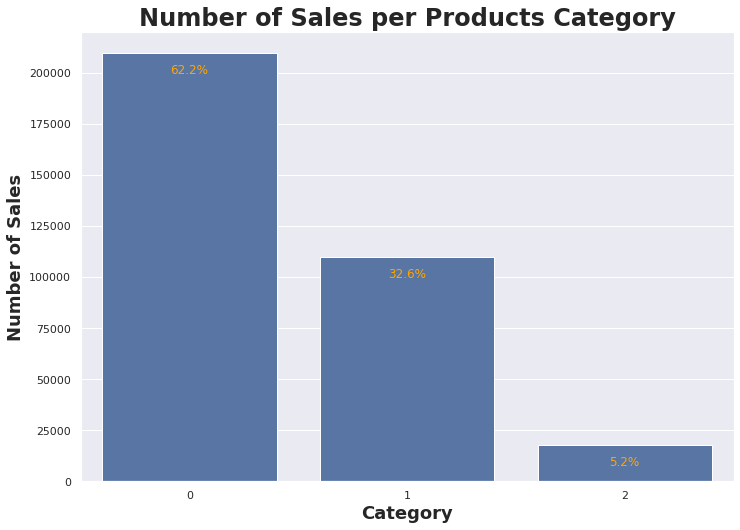

In [59]:
# Choose a standard color for the plot
base_color = sns.color_palette()[0]
# Barplot of the categories
sns.countplot(data = sales_clean, x = "category", color = base_color)
plt.title("Number of Sales per Products Category", fontsize = 24, fontweight = "bold")
plt.xlabel(xlabel = "Category", fontsize = 18, fontweight = "bold")
plt.ylabel(ylabel = "Number of Sales", fontsize = 18, fontweight = "bold")
# Add some annotations
number_points = sales_clean.shape[0]        # number of points in the dataset
category_counts = sales_clean.category.value_counts() # all Values of the categories
locs, labels = plt.xticks()   # Current tick locations and labels
# Loop through each pair of locations and labels  
for loc, label in zip(locs, labels):
    # Text property for the label to get the current count
    count = category_counts[label.get_text()]
    percentage = '{:0.1f}%'.format(100*count/number_points) # Percentage of each category
    # Put the annotations inside the bar on the top
    plt.text(x = loc, y = count-10000, s = percentage, ha = 'center', color = 'orange')

**62%** of the sales are in category 0, **33%** in category 1 and just **5.2%** in category 2. 

**What is the Average sale in each category?**

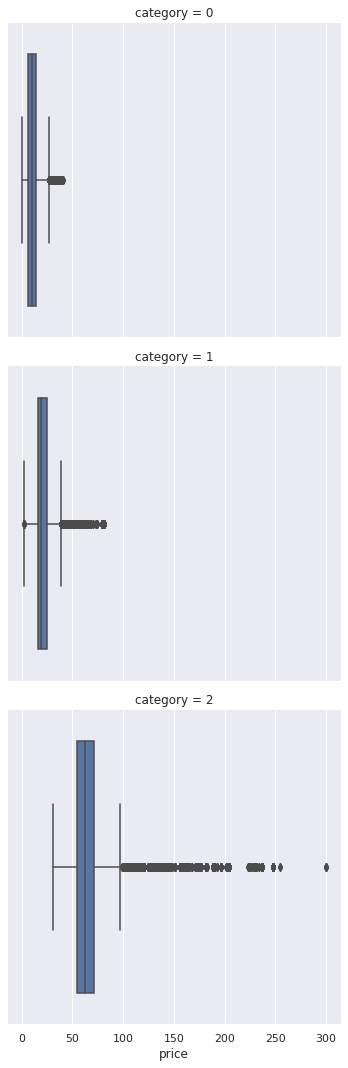

In [60]:
# Considering all the dataframe
sns.catplot(x = "price", data = sales_clean, kind = "box", row = "category");

In [61]:
for i in range(3):
    print("Mean Category " + str(i) + ": ", sales_clean.price[sales_clean.category == str(i)].mean())
    print("Median Category " + str(i) + ": ", sales_clean.price[sales_clean.category == str(i)].median())
    print("Mode Category " + str(i) + ": ", sales_clean.price[sales_clean.category == str(i)].mode()[0])
    print("Standard Deviation Category " + str(i) + ":", sales_clean.price[sales_merge.category == str(i)].std(),"\n")    

Mean Category 0:  10.648427425323296
Median Category 0:  9.99
Mode Category 0:  4.99
Standard Deviation Category 0: 4.929345339563638 

Mean Category 1:  20.4801058003428
Median Category 1:  19.08
Mode Category 1:  15.99
Standard Deviation Category 1: 7.568956079961025 

Mean Category 2:  75.17494929352519
Median Category 2:  62.83
Mode Category 2:  68.99
Standard Deviation Category 2: 39.0799988187327 



The average price in category `0 is $10, in category 1 it is $19 and in category 2 it is $62`. 
There are many outliers in all categories. we take as average the median.

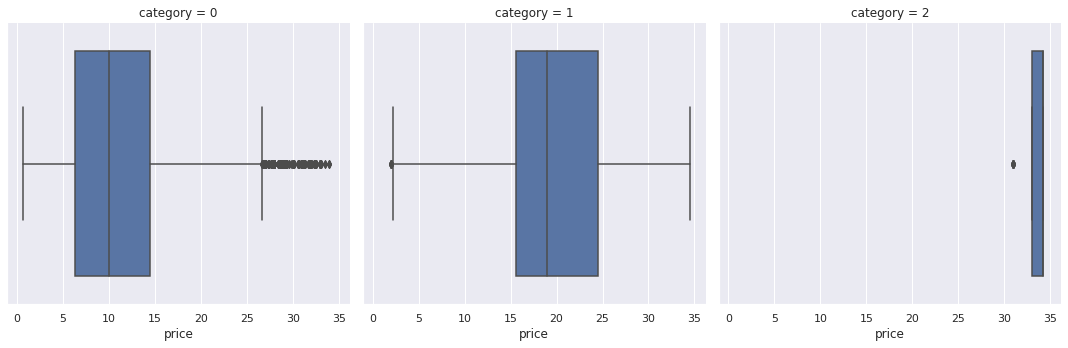

In [62]:
# Average sales in each category removing outliers
sns.catplot(x = "price", data = sales_clean_no_outliers, kind = "box", col = "category");

In [63]:
# measures of center df without outliers
for i in range(3):
    print("Mean Category " + str(i) + ": ", sales_clean_no_outliers.price[sales_clean_no_outliers.category == str(i)].mean())
    print("Median Category " + str(i) + ": ", sales_clean_no_outliers.price[sales_clean_no_outliers.category == str(i)].median())
    print("Mode Category " + str(i) + ": ", sales_clean_no_outliers.price[sales_clean_no_outliers.category == str(i)].mode()[0])
    print("Standard Deviation Category " + str(i) + ":", sales_clean_no_outliers.price[sales_merge.category == str(i)].std(),"\n")

Mean Category 0:  10.63737482155133
Median Category 0:  9.99
Mode Category 0:  4.99
Standard Deviation Category 0: 4.9006383705794745 

Mean Category 1:  19.751837108982308
Median Category 1:  18.99
Mode Category 1:  15.99
Standard Deviation Category 1: 5.939520677816348 

Mean Category 2:  33.504698795180715
Median Category 2:  34.23
Mode Category 2:  34.23
Standard Deviation Category 2: 1.181694047883549 



It seems that all the outiers values are from product of category 2. Product of category 2 are the most expensives.

**Distribution of Age**

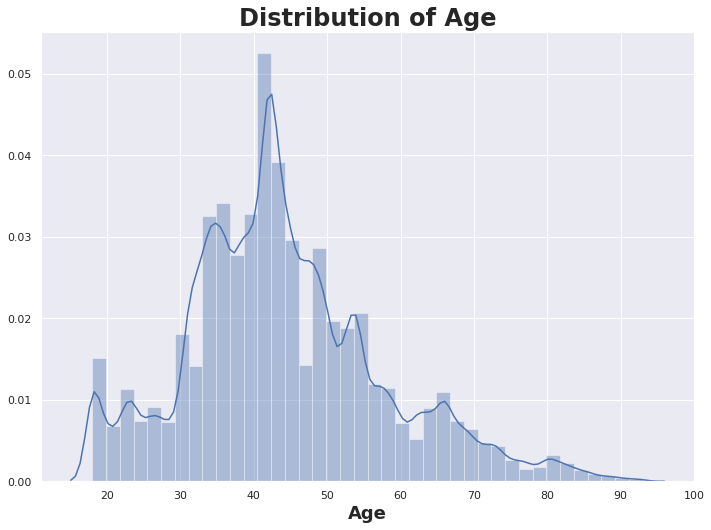

In [64]:
sns.distplot(sales_clean.age, bins = 40)
plt.xlabel("Age", fontsize = 18, fontweight = "bold")
plt.title("Distribution of Age", fontsize = 24, fontweight = "bold");

Most of the sales come from people aged between 30 and 55 with a peak at 42 years old.

**Sales by Gender**

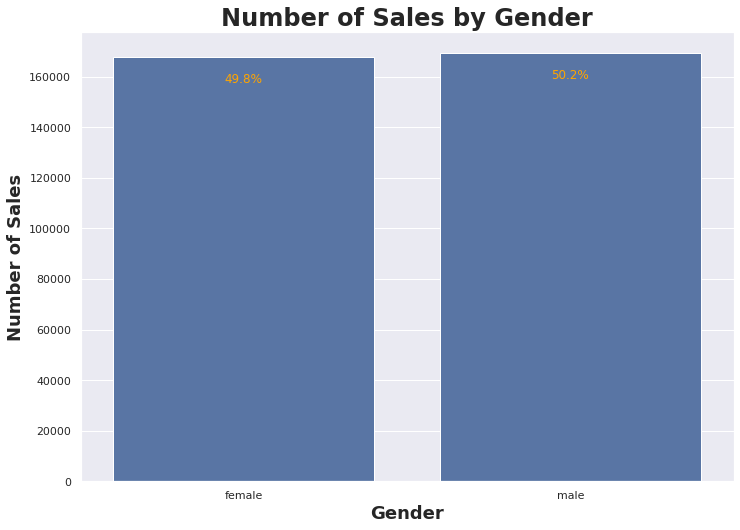

In [65]:
# Choose a standard color for the plot
base_color = sns.color_palette()[0]
# Barplot of the categories
sns.countplot(data = sales_clean, x = "gender", color = base_color)
plt.title("Number of Sales by Gender", fontsize = 24, fontweight = "bold")
plt.xlabel(xlabel = "Gender", fontsize = 18, fontweight = "bold")
plt.ylabel(ylabel = "Number of Sales", fontsize = 18, fontweight = "bold")
# Add some annotations
number_points = sales_clean.shape[0]        # number of points in the dataset
category_counts = sales_clean.gender.value_counts() # all Values of each category
locs, labels = plt.xticks()   # Current tick locations and labels
# Loop through each pair of locations and labels  
for loc, label in zip(locs, labels):
    # Text property for the label to get the current count
    count = category_counts[label.get_text()]
    percentage = '{:0.1f}%'.format(100*count/number_points) # Percentage of each category
    # Put the annotations inside the bar on the top
    plt.text(x = loc, y = count-10000, s = percentage, ha = 'center', color = 'orange')

The number of sales is almost the same for each gender.

**Sales over time**

Check all the date availaible.

In [66]:
# Check the years 
sales_clean.date.dt.year.unique()

array([2021, 2022])

In [67]:
# Check the last date of 2022
sales_clean.date.max()

Timestamp('2022-02-28 23:59:58.040472')

We have data for 2021 and 2022. For 2022 we have just January and February.

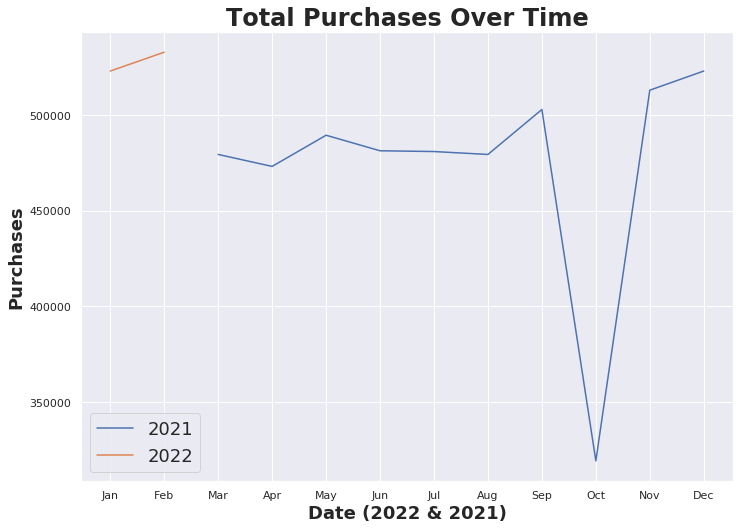

In [68]:
# Time series of the price each month just for 2021
sales_clean_21 = sales_clean[sales_clean.date.dt.year == 2021]
sales_clean_22 = sales_clean[sales_clean.date.dt.year == 2022]
g_21 = sales_clean_21.groupby(sales_clean_21.date.dt.month).price.sum().reset_index() # We group by months of 2021
g_22 = sales_clean_22.groupby(sales_clean_22.date.dt.month).price.sum().reset_index() # We group by months of 2022
fig, ax = plt.subplots()
ax.plot(g_21.date, g_21.price)
ax.plot(g_22.date, g_22.price)
plt.legend(["2021", "2022"], fontsize = 18)
plt.title("Total Purchases Over Time", fontsize = 24, fontweight = "bold")
plt.xlabel("Date (2022 & 2021)", fontsize = 18, fontweight = "bold")
plt.ylabel("Purchases", fontsize = 18, fontweight = "bold")

plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12],["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]);

In 2021 December is the month with the most sales, while October is the worse. Overall february is the month with the most sales.
There is a high drop in october, let's go deep to see what is really happening.

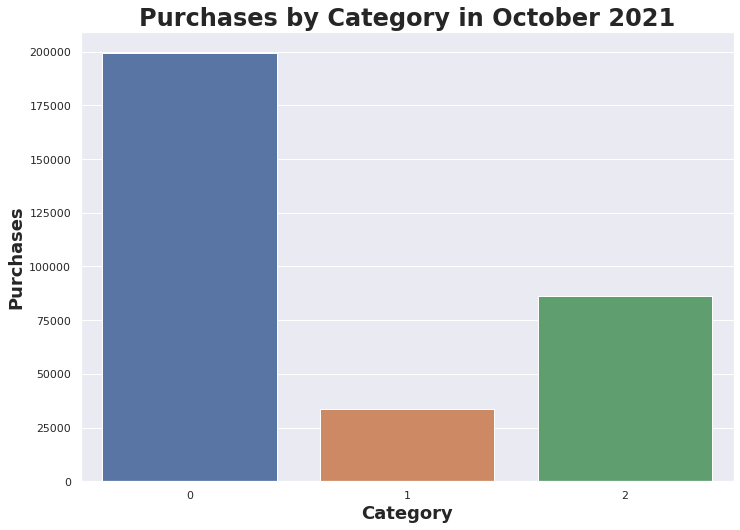

In [69]:
# Compute the dataframe with just october
sales_clean_oct = sales_clean[sales_clean.date.dt.month == 10]
# Group by category 
g_oct = sales_clean_oct.groupby("category").price.sum().reset_index()
sns.barplot("category", "price", data = g_oct)
plt.xlabel("Category", fontsize = 18, fontweight = "bold")
plt.ylabel("Purchases", fontsize = 18, fontweight = "bold")
plt.title("Purchases by Category in October 2021", fontsize = 24, fontweight = "bold");

The Sales in October are very low for the category 1, let's go deep by checking each day of that month.

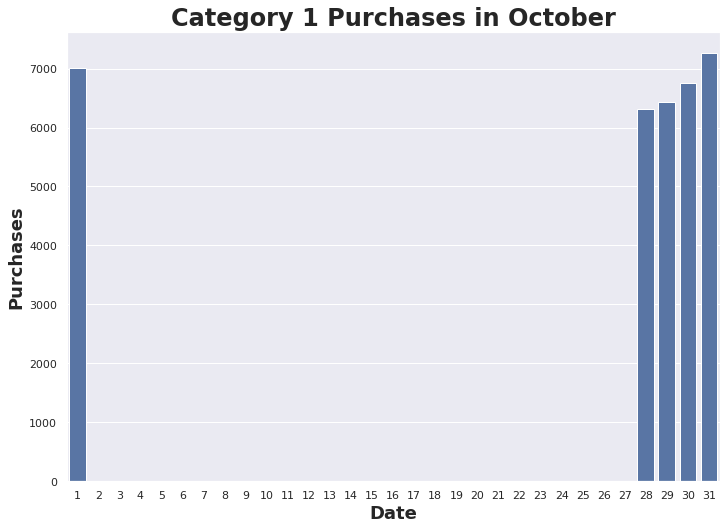

In [70]:
# Dataframe of all the days of october, we group by category and days
sales_oct = sales_clean_oct.groupby(["category", sales_clean_oct.date.dt.day]).sum().reset_index()
# Filter just for category 1
sales_oct_1 = sales_oct[sales_oct.category == "1"]
sns.barplot("date", "price",data = sales_oct_1, color = "b", ci = None)
plt.xlabel("Date", fontsize = 18, fontweight = "bold")
plt.ylabel("Purchases", fontsize = 18, fontweight = "bold")
plt.title("Category 1 Purchases in October", fontsize = 24, fontweight = "bold");

We can clearly see that from the 2th to the 27th there were no sales. Maybe there was a lack of product that period, this is to investigate.

**What is the day of the week with the most sales over time?**

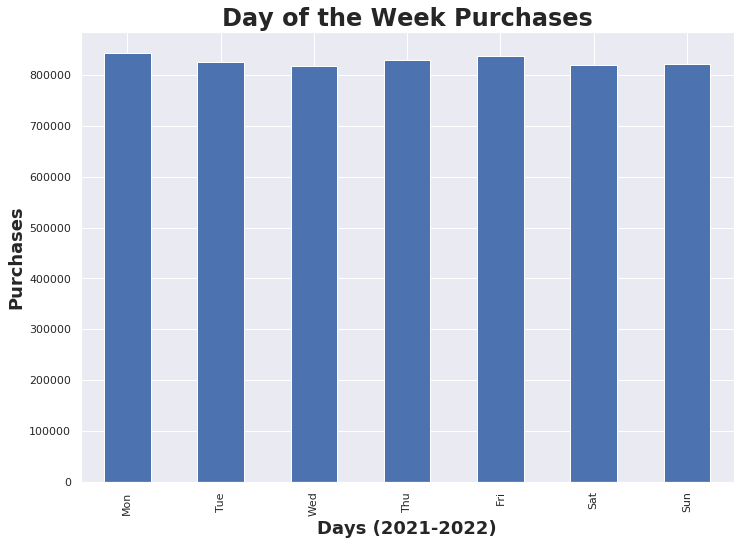

In [71]:
# Group by day and plot
sales_clean.groupby(sales_clean.date.dt.dayofweek).price.sum().plot(kind = "bar")
plt.xlabel("Days (2021-2022)", fontsize = 18, fontweight = "bold")
plt.ylabel("Purchases", fontsize = 18, fontweight = "bold")
plt.title("Day of the Week Purchases", fontsize = 24, fontweight = "bold")
plt.xticks([0,1,2,3,4,5,6],["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]);

All the days of the week have almost the same amount of purchases, so there is not a better day for sales.

**Concentration of sales - Lorenz Curve**

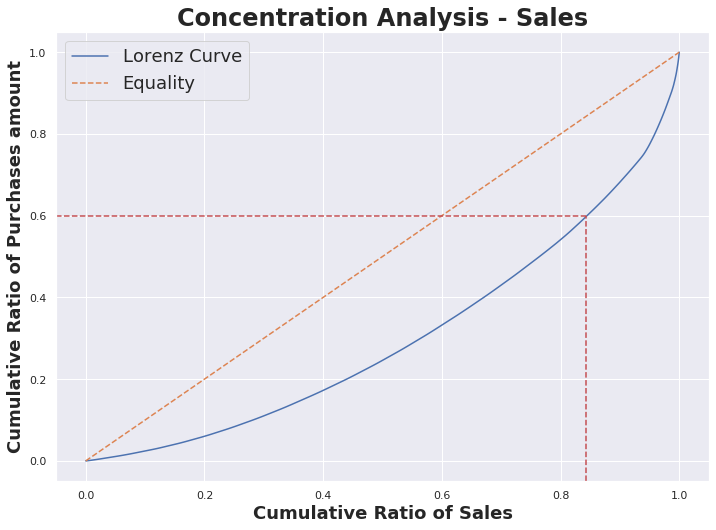

In [72]:
# Plot the lorenz curve
n = len(sales_clean.price) #size of the sample
lorenz = np.cumsum(np.sort(sales_clean.price) / sales_clean.price.sum()) #result will be an array
lorenz = np.append([0], lorenz) #values of the y axis on the curve, the curve will begin at 0

# plt.axes().axis("equal") #x and y axis will have the same length
xaxis = np.linspace(-1/n, 1+1/n, n+1) #values of the x axis on the curve
plt.plot(xaxis, lorenz, drawstyle = "steps-post")
plt.plot(xaxis, xaxis, linestyle="--") #Plot the 1st bissector
plt.ylabel("Cumulative Ratio of Purchases amount", fontsize = 18, fontweight = "bold")
plt.xlabel("Cumulative Ratio of Sales", fontsize = 18, fontweight = "bold")
plt.legend(["Lorenz Curve", "Equality"], loc = "upper left", fontsize = 18)
plt.axvline(0.843, ymax = 0.59, linestyle = "--", color = "r")
plt.axhline(0.6, xmax = 0.813, linestyle = "--", color = "r")
plt.title("Concentration Analysis - Sales", fontsize = 24, fontweight = "bold");

**Gini Coefficient**

In [73]:
# compute gini coefficient
AUC = (lorenz.sum() - lorenz[-1]/2 - lorenz[0]/2)/n # Area under the curve
S = 0.5 - AUC # Area between the curve and the 1st bissector
gini = round(2*S,1)*100
gini

40.0

We have a gini coefficient of around 40%, which means there is inequality.
Bottom 84% of the sales just give 60% of the total purchases amount.

### Correlations

**Correlation between Gender and Category**

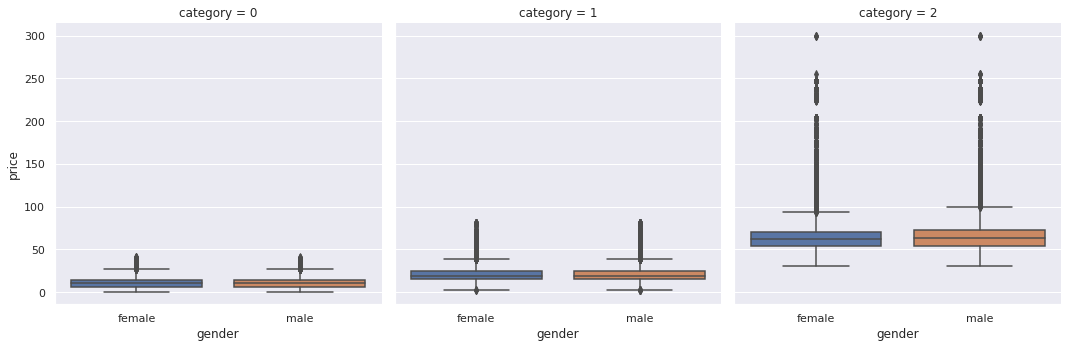

In [74]:
# violin plot, gender and categories of products purchased
sns.catplot(x = "gender", y = "price", col = "category", kind = "box" , data = sales_clean);

We can see that in each category gender are almost simmetrical, this means that there is no difference of purchase between gender in each category.

In [75]:
# Contigency table
gender_category_table = pd.crosstab(index = sales_clean.category, columns = sales_clean.gender)
gender_category_table

gender,female,male
category,,
0,103846,105683
1,55469,54266
2,8260,9292


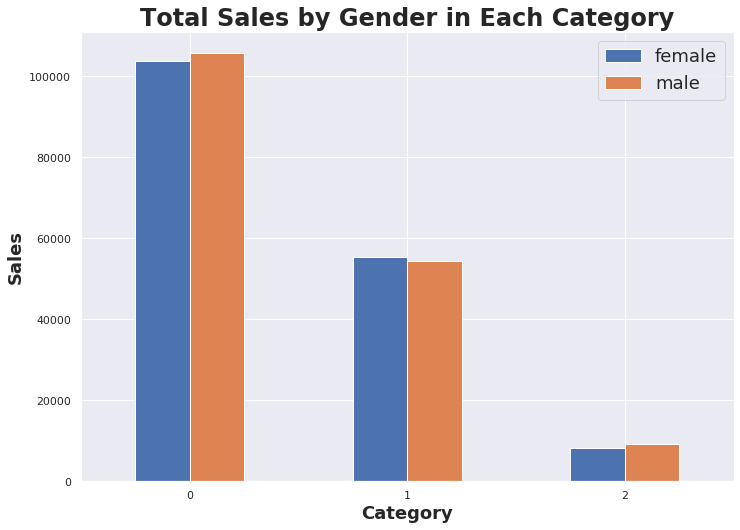

In [76]:
gender_category_table.plot(kind="bar", rot= 0)
plt.title("Total Sales by Gender in Each Category", fontsize = 24, fontweight = "bold")
plt.xlabel("Category", fontsize = 18, fontweight = "bold")
plt.ylabel("Sales", fontsize = 18, fontweight = "bold")
plt.legend(fontsize = 18, loc = "upper right");

Our hypothesis.
>   H0 : Gender and Category are independant  
    H1: Gender and Category are dependant

In [77]:
stat, p, dof, expected = sci.chi2_contingency(gender_category_table)
if p > 0.01:
    print("Gender and Category are probably independent")
else:
    print("Gender and Category are probably dependent")

Gender and Category are probably dependent


There are more sales in category 0 and very few in category 2, even if category sales 2 has products with higher prices.   
In category **0** *Male* make more purchases than *Female*.  
In category **1** *Female* make more purchases than *Male*.  
In category **2** *Male* make more purchases than *Female*. 

**Correlation between age and total amount of purchases**

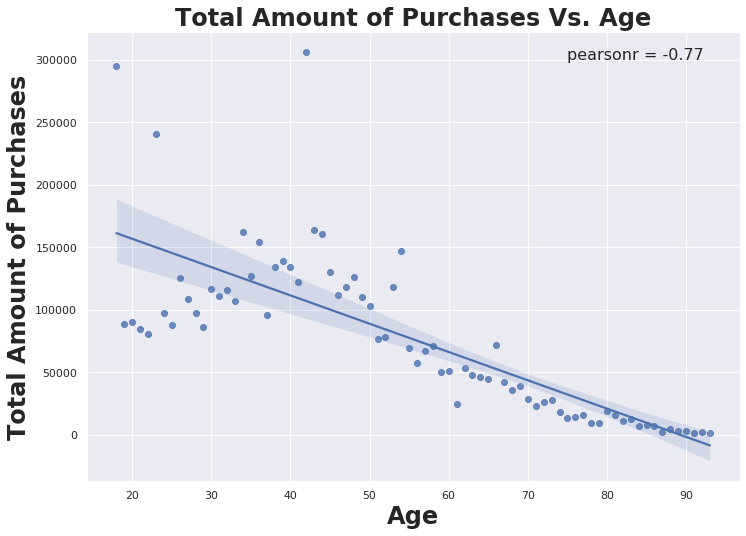

In [78]:
# Create a dataframe with age and the total amount purchases
corr_age_price = sales_clean.groupby("age").sum().reset_index()
# Compute the pearsonr 
r_age_price = sci.pearsonr(corr_age_price.price, corr_age_price.age)[0]
# Plot using regplot
sns.regplot(x = "age", y = "price", data = corr_age_price)
plt.xlabel("Age", fontsize = 24, fontweight = "bold")
plt.ylabel("Total Amount of Purchases", fontsize = 24, fontweight = "bold")
plt.title("Total Amount of Purchases Vs. Age", fontsize = 24, fontweight = "bold")
plt.text(s = "pearsonr = {:.2f}".format(r_age_price), y = 300000, x = 75, fontsize = 16);


There is a strong negative correlation between the age and the amount of purchases, as the age increases the amount of purchases decreases.  
Young people buy more than old people. 

**Correlation between age and the purchase frequency(Number of purchases per month)**

In [79]:
# Compute a group_age variable
def group_age(age):
    if age >= 18 and age < 35:
        return "18-34"
    elif age >= 35 and age < 61:
        return "35-60"
    elif age >= 61:
        return "61+"
sales_clean["group_age"] = sales_clean.age.apply(group_age).astype("category")

**Correlation between age and the categories of purchases products**

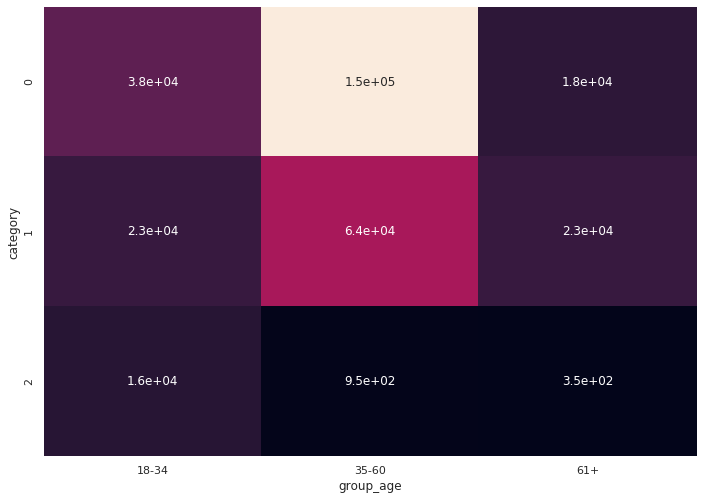

In [80]:
group_age_category_table = pd.crosstab(index = sales_clean.category, columns = sales_clean.group_age)
sns.heatmap(group_age_category_table, annot = True, cbar = False);

Our hypothesis.
>   `H0 : Age and Category are independant`  
    `H1: Age and Category are dependant`

In [81]:
stat, p, dof, expected = sci.chi2_contingency(group_age_category_table)
if p > 0.01:
    print("age and Category are probably independent") # We fail to reject the null hypothesis
else:
    print("age and Category are probably dependent") # We reject the null hypothesis

age and Category are probably dependent


For all ages there are more sales in category 0 and less in category 2.  
People aged between 35-60 make more purchases in category 0 and 1 compared to other age group.

**Correlation between age and the average basket size (in number of items)**

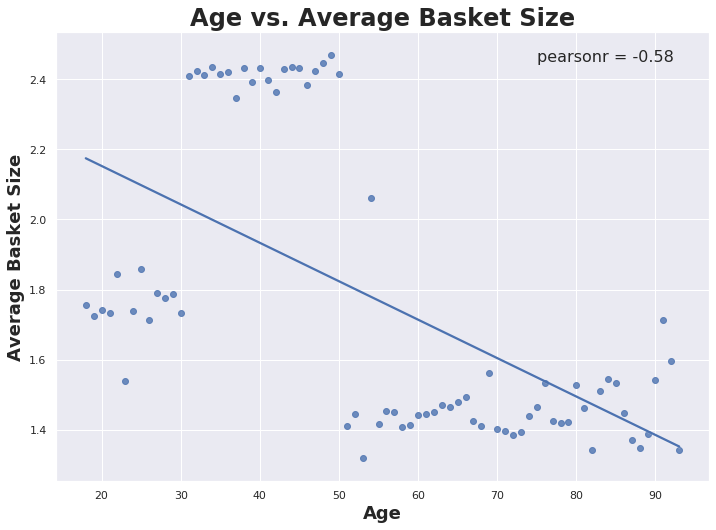

In [82]:
# compute the average basket size
age_average_basket = sales_clean.groupby(["age", "session_id"]).count().reset_index().groupby("age")["id_prod"].mean().reset_index()
sns.regplot("age", "id_prod", data = age_average_basket, ci = False)
plt.xlabel("Age", fontsize = 18, fontweight = "bold")
plt.ylabel("Average Basket Size", fontsize = 18, fontweight = "bold")
plt.title("Age vs. Average Basket Size", fontsize = 24, fontweight = "bold")
r_age_average_basket = sci.pearsonr(age_average_basket.age, age_average_basket.id_prod)[0]
plt.text(s = "pearsonr = {:.2f}".format(r_age_average_basket), x = 75, y = 2.45, fontsize = 16);

There is a correlation between age and the average basket size.  
Young people (< 50 years old) have an average basket size higher than older people. As we could expect we have a pick
between people aged 30 to 50 years old which is the range where we have the highest sales.